In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
img = cv2.imread('star.jpeg', cv2.IMREAD_GRAYSCALE)

image_h, image_w = img.shape

sigma_base = 0.707
k = np.sqrt(2)
octaves = []

for octave_i in range(4):
    
    if octave_i == 0:
        current_img = img
    else:
       
        current_img = cv2.resize(current_img, (current_img.shape[1]//2, current_img.shape[0]//2), interpolation=cv2.INTER_LINEAR)
    
    sigma_values = []
    gaussian_images = []
    
    
    for scale_i in range(5):
        current_sigma = sigma_base * (k ** scale_i)
        sigma_values.append(current_sigma)
        
        blurred_img = cv2.GaussianBlur(current_img, (0, 0), sigmaX=current_sigma, sigmaY=current_sigma, borderType=cv2.BORDER_DEFAULT)
        gaussian_images.append(blurred_img)
    
    
    octaves.append({
        'gaussian_images': gaussian_images,
        'sigma_values': sigma_values,
        'shape': current_img.shape
    })

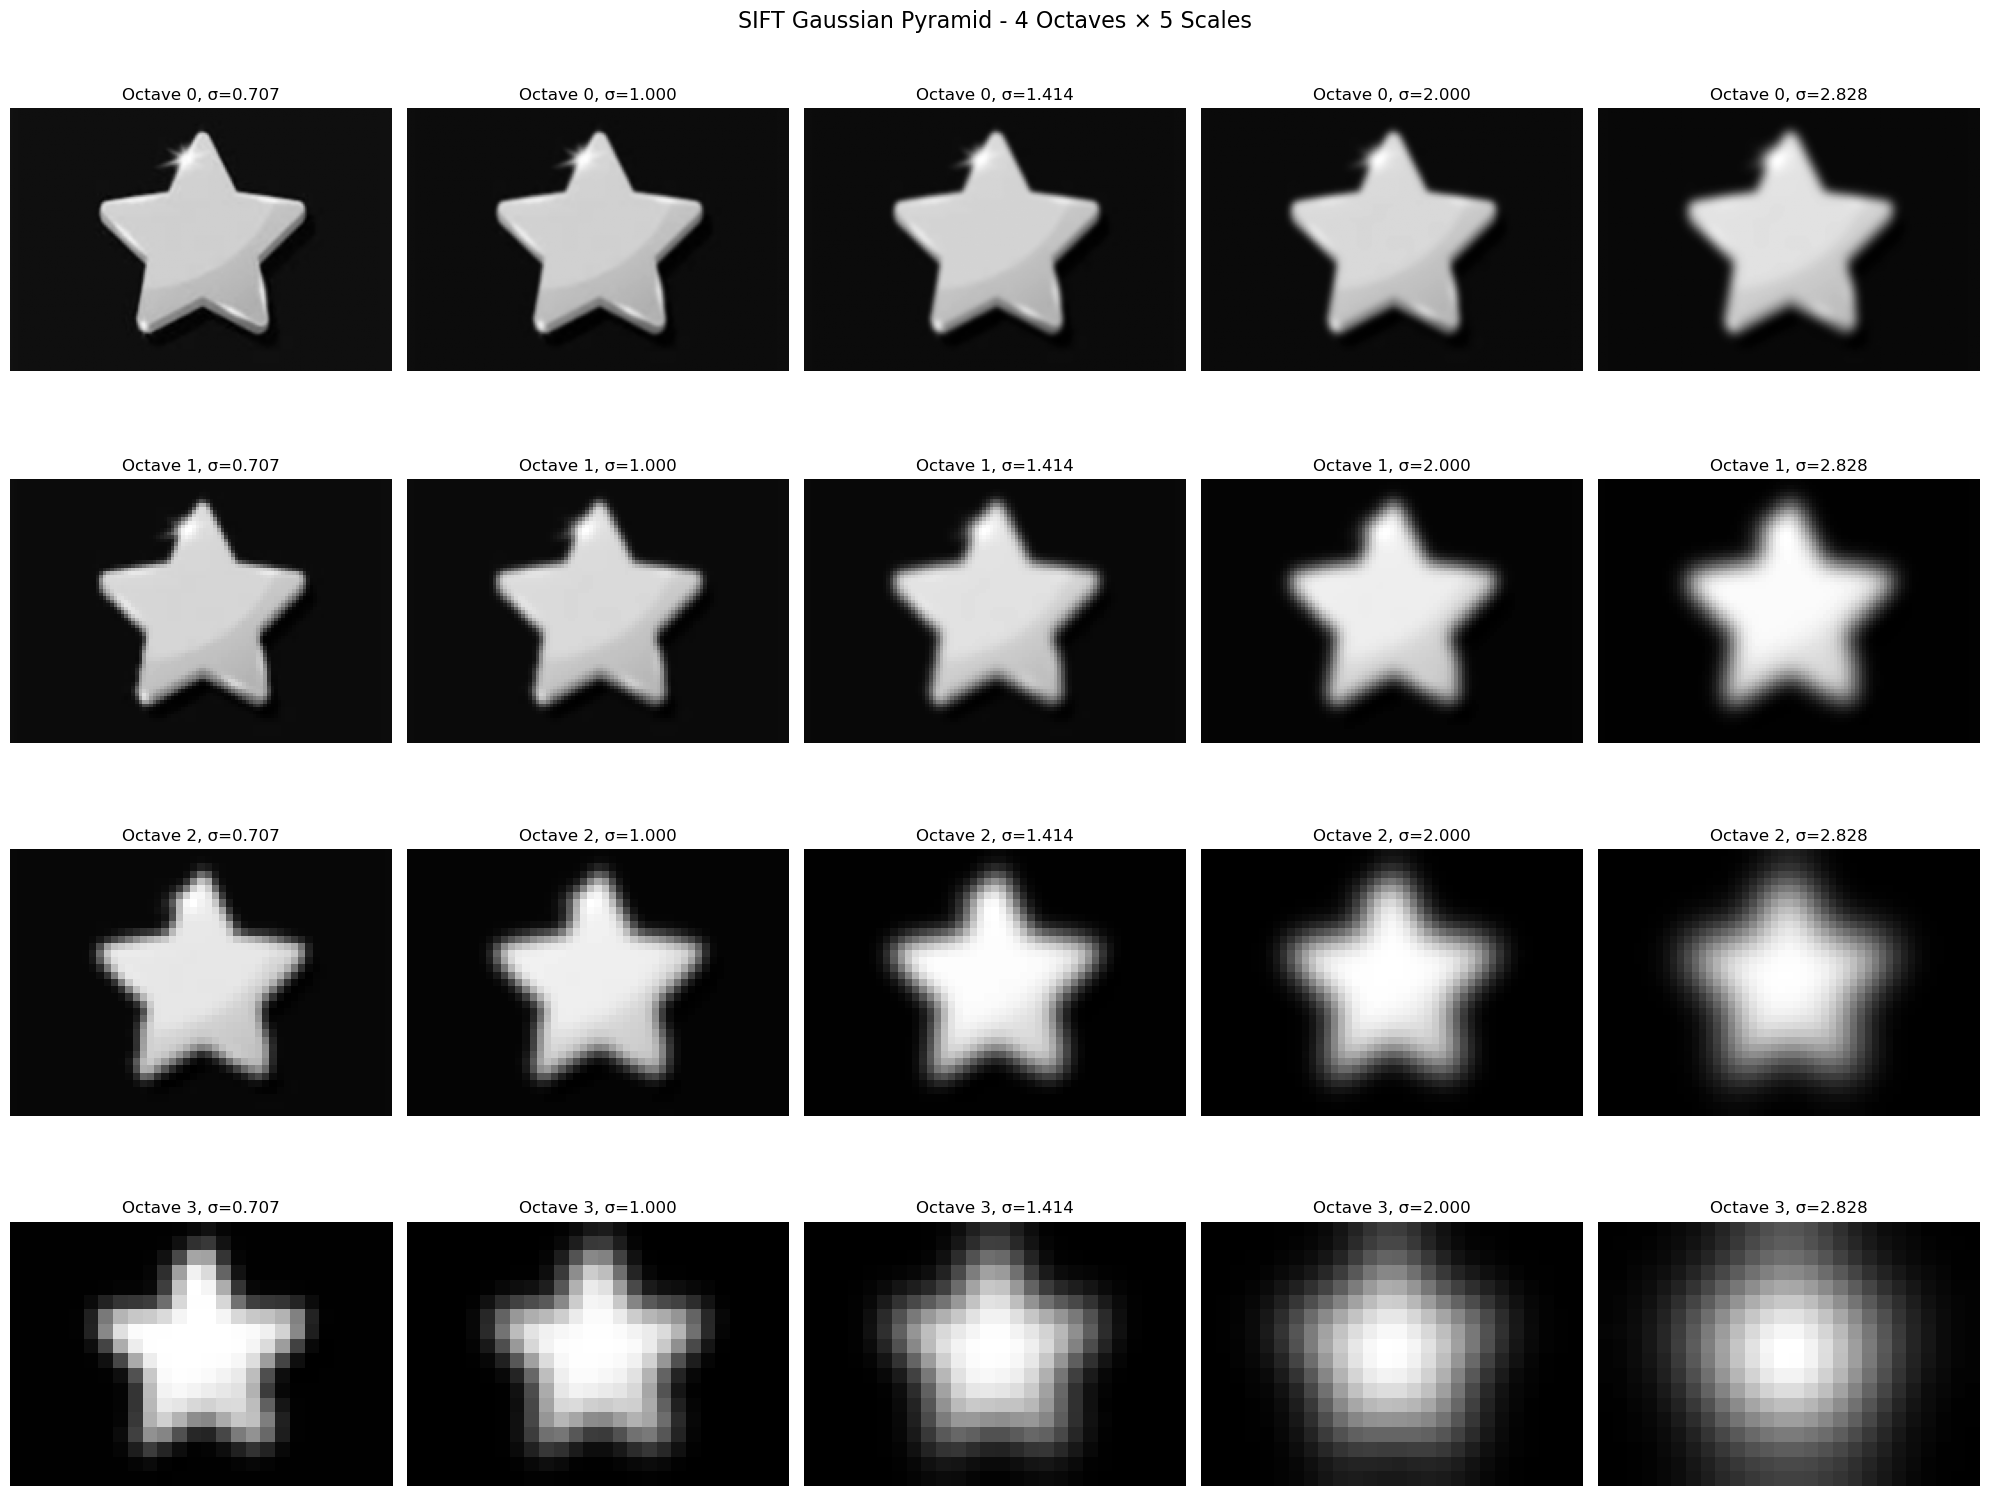

In [3]:



fig, axes = plt.subplots(4, 5, figsize=(20, 16))
fig.suptitle('SIFT Gaussian Pyramid - 4 Octaves × 5 Scales', fontsize=16)

for octave_i in range(4):
    for scale_i in range(5):
        ax = axes[octave_i, scale_i]
        img_to_show = octaves[octave_i]['gaussian_images'][scale_i]
        sigma_val = octaves[octave_i]['sigma_values'][scale_i]
        
        ax.imshow(img_to_show, cmap='gray')
        ax.set_title(f'Octave {octave_i}, σ={sigma_val:.3f}')
        ax.axis('off')

plt.tight_layout()
plt.show()

In [4]:

dog_octaves = []

for octave_i in range(4):
    dog_images = []
    
    
    for scale_i in range(4):  
        img1 = octaves[octave_i]['gaussian_images'][scale_i]
        img2 = octaves[octave_i]['gaussian_images'][scale_i + 1]
        
       
        dog = img2 - img1 
        dog_images.append(dog)
    
    dog_octaves.append({
        'dog_images': dog_images,
        'shape': octaves[octave_i]['shape']
    })


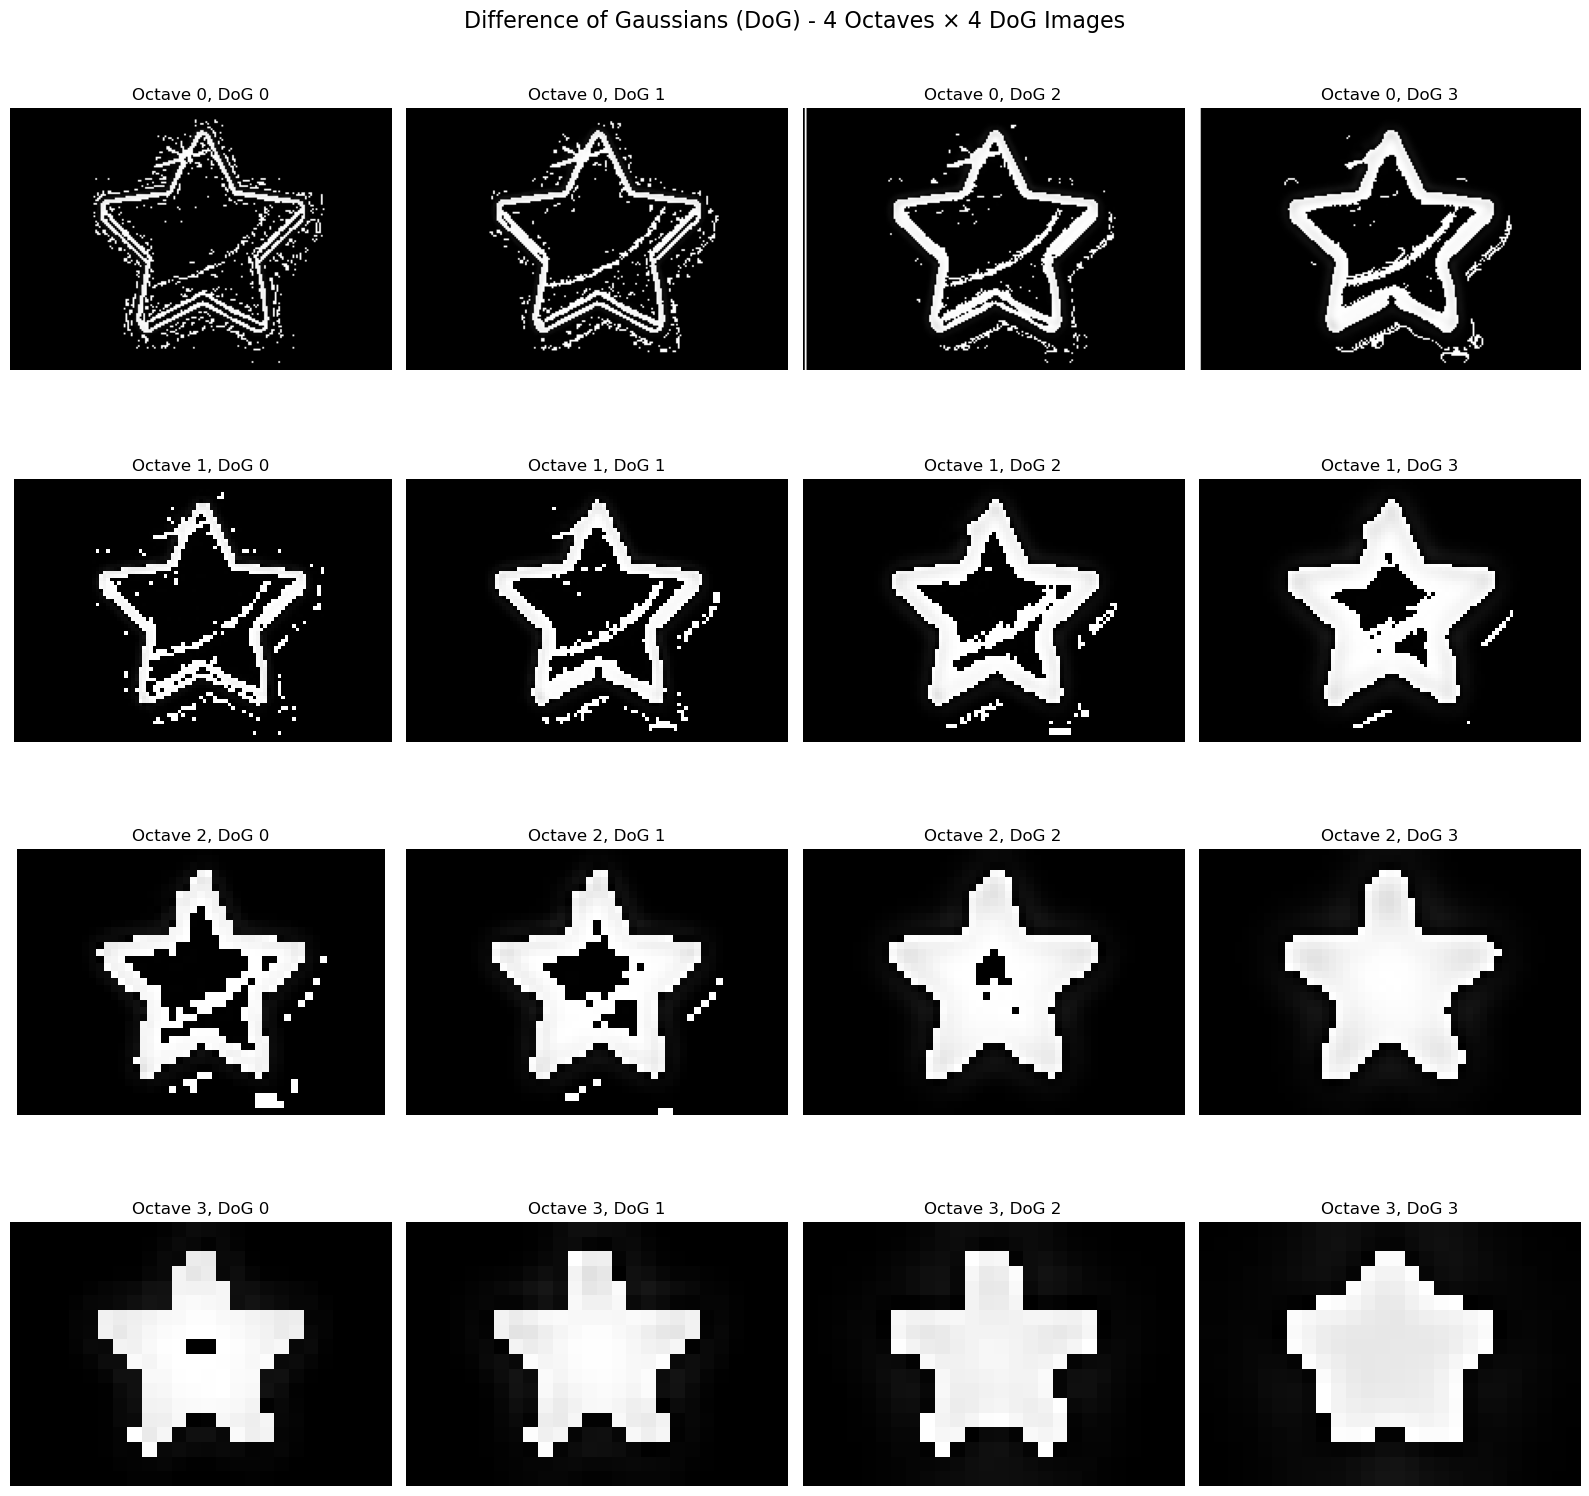

In [5]:

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
fig.suptitle('Difference of Gaussians (DoG) - 4 Octaves × 4 DoG Images', fontsize=16)

for octave_i in range(4):
    for dog_i in range(4):
        ax = axes[octave_i, dog_i]
        dog_img = dog_octaves[octave_i]['dog_images'][dog_i]
        
       
        ax.imshow(dog_img, cmap='gray')
        ax.set_title(f'Octave {octave_i}, DoG {dog_i}')
        ax.axis('off')

plt.tight_layout()
plt.show()


In [6]:

for octave_i, octave_data in enumerate(dog_octaves):
    print(f"\nOctave {octave_i}:")
    print(f"  Shape: {octave_data['shape']}")
    


Octave 0:
  Shape: (148, 215)

Octave 1:
  Shape: (74, 107)

Octave 2:
  Shape: (37, 53)

Octave 3:
  Shape: (18, 26)


In [ ]:
edge_threshold = 0.1
contrast_threshold = 0.04
keypoints = []  # list of tuples (x, y, sigma, octave, dog)

for octave_i in range(4):
    dog_images = dog_octaves[octave_i]['dog_images']
    sigma_values = octaves[octave_i]['sigma_values']
    h, w = dog_octaves[octave_i]['shape']

    for dog_i in range(1, 3):  # Skip the first and last DoG
        prev_dog = dog_images[dog_i - 1]
        current_dog = dog_images[dog_i]
        next_dog = dog_images[dog_i + 1]

        for y in range(1, h - 1):
            for x in range(1, w - 1):
                center_value = current_dog[y, x]

                cube = np.stack([
                    prev_dog[y-1:y+2, x-1:x+2],
                    current_dog[y-1:y+2, x-1:x+2],
                    next_dog[y-1:y+2, x-1:x+2]
                ])

                if (center_value == cube.max() or center_value == cube.min()) and abs(center_value) > contrast_threshold:
                    # Hessian edge check
                    Dxx = current_dog[y, x+1] + current_dog[y, x-1] - 2 * center_value
                    Dyy = current_dog[y+1, x] + current_dog[y-1, x] - 2 * center_value
                    Dxy = (current_dog[y+1, x+1] - current_dog[y+1, x-1]
                           - current_dog[y-1, x+1] + current_dog[y-1, x-1]) / 4.0

                    detH = Dxx * Dyy - Dxy**2
                    traceH = Dxx + Dyy

                    if detH > 0:
                        r = (traceH**2) / detH
                        r_thresh = ((edge_threshold + 1)**2) / edge_threshold
                        if r < r_thresh:
                            # Get corresponding sigma value for this DoG
                            sigma = sigma_values[dog_i]
                            x_real = x * (2 ** octave_i)
                            y_real = y * (2 ** octave_i)
                            keypoints.append((x_real, y_real, sigma, octave_i, dog_i))

    print(f"Octave {octave_i}: {len(keypoints)} keypoints so far")

print(f"\nTotal keypoints detected: {len(keypoints)}")


print("\nSample of keypoints with σ values (x, y, σ, octave, dog):")
for i, (x, y, sigma, octave, dog) in enumerate(keypoints[:20]):  # print first 20
    print(f"Keypoint {i+1}: x={x:.2f}, y={y:.2f}, σ={sigma:.3f}, octave={octave}, dog={dog}")



/tmp/ipykernel_11122/1862946267.py:29: RuntimeWarning: overflow encountered in scalar subtract
  Dxy = (current_dog[y+1, x+1] - current_dog[y+1, x-1]
/tmp/ipykernel_11122/1862946267.py:29: RuntimeWarning: overflow encountered in scalar add
  Dxy = (current_dog[y+1, x+1] - current_dog[y+1, x-1]
/tmp/ipykernel_11122/1862946267.py:28: RuntimeWarning: overflow encountered in scalar add
  Dyy = current_dog[y+1, x] + current_dog[y-1, x] - 2 * center_value
/tmp/ipykernel_11122/1862946267.py:27: RuntimeWarning: overflow encountered in scalar add
  Dxx = current_dog[y, x+1] + current_dog[y, x-1] - 2 * center_value


Octave 0: 2412 keypoints so far
Octave 1: 3029 keypoints so far
Octave 2: 3156 keypoints so far
Octave 3: 3171 keypoints so far

Total keypoints detected: 3171

Sample of keypoints with σ values (x, y, σ, octave, dog):
Keypoint 1: x=108.00, y=7.00, σ=1.000, octave=0, dog=1
Keypoint 2: x=115.00, y=8.00, σ=1.000, octave=0, dog=1
Keypoint 3: x=108.00, y=9.00, σ=1.000, octave=0, dog=1
Keypoint 4: x=115.00, y=9.00, σ=1.000, octave=0, dog=1
Keypoint 5: x=116.00, y=9.00, σ=1.000, octave=0, dog=1
Keypoint 6: x=119.00, y=9.00, σ=1.000, octave=0, dog=1
Keypoint 7: x=120.00, y=9.00, σ=1.000, octave=0, dog=1
Keypoint 8: x=111.00, y=10.00, σ=1.000, octave=0, dog=1
Keypoint 9: x=116.00, y=10.00, σ=1.000, octave=0, dog=1
Keypoint 10: x=120.00, y=10.00, σ=1.000, octave=0, dog=1
Keypoint 11: x=116.00, y=11.00, σ=1.000, octave=0, dog=1
Keypoint 12: x=119.00, y=11.00, σ=1.000, octave=0, dog=1
Keypoint 13: x=88.00, y=15.00, σ=1.000, octave=0, dog=1
Keypoint 14: x=118.00, y=15.00, σ=1.000, octave=0, dog=1


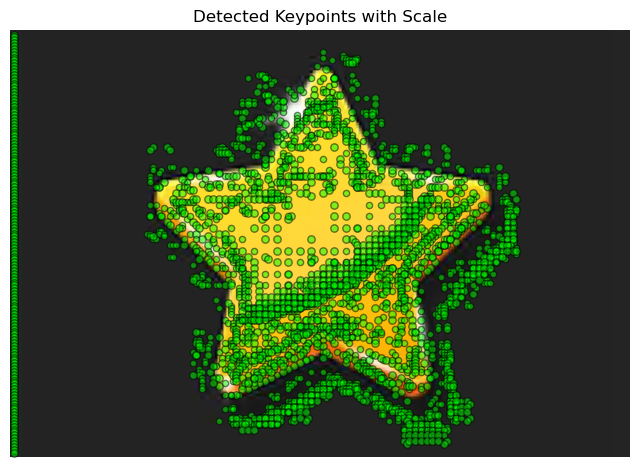

In [12]:
plt.figure(figsize=(8, 8))
image_rgb = cv2.cvtColor(cv2.imread('star.jpeg'), cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title("Detected Keypoints with Scale")
plt.axis('off')

for (x, y, sigma, _, _) in keypoints:
    plt.scatter(x, y, s=(sigma * 20), c='lime', alpha=0.5, edgecolors='black')

plt.show()


Step 1: Assigning orientations to keypoints...
Initial oriented keypoints: 5757

Step 2: Applying non-maximum suppression...
After NMS: 1070

Step 3: Computing SIFT descriptors...
Valid descriptors: (1040, 128)
Each descriptor is 128-dimensional

Step 4: Visualizing keypoints with orientations...


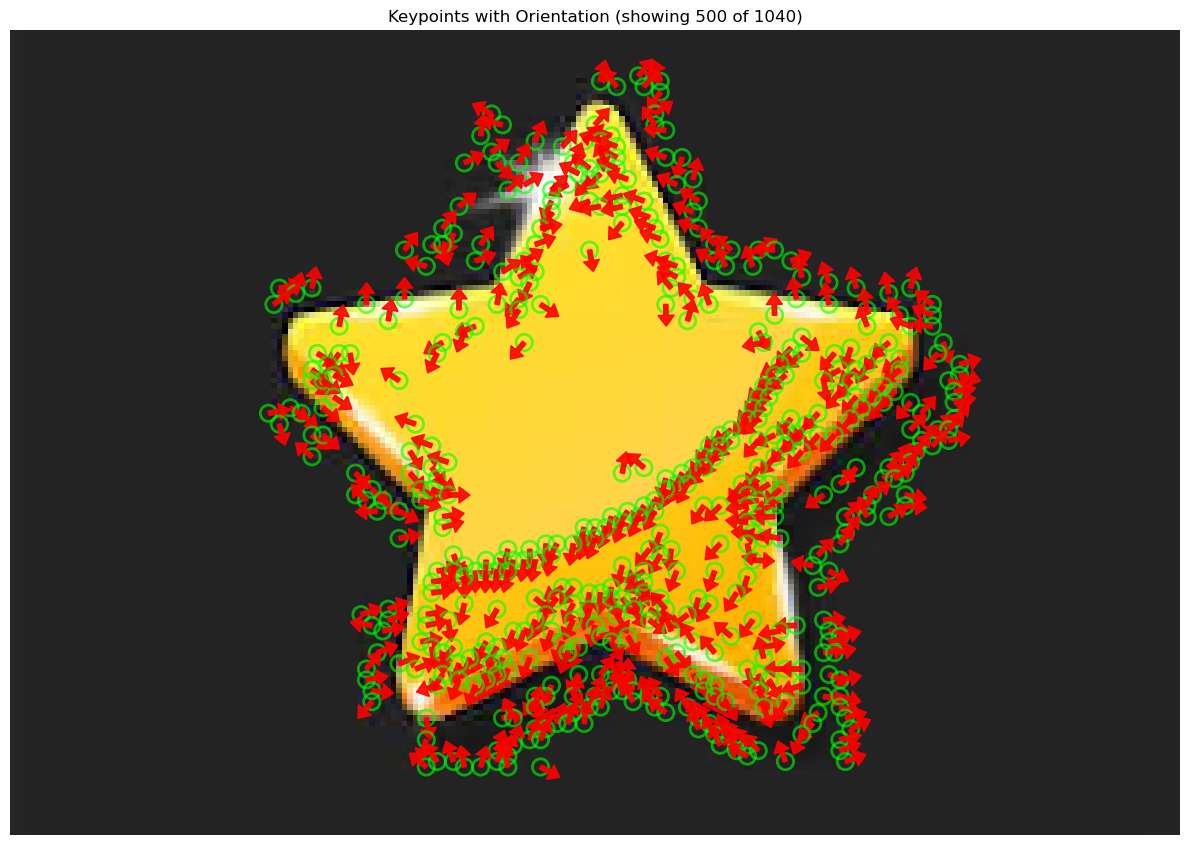


Step 5: Comparing with OpenCV SIFT...

OpenCV SIFT: 48 keypoints, Descriptor shape: (48, 128)


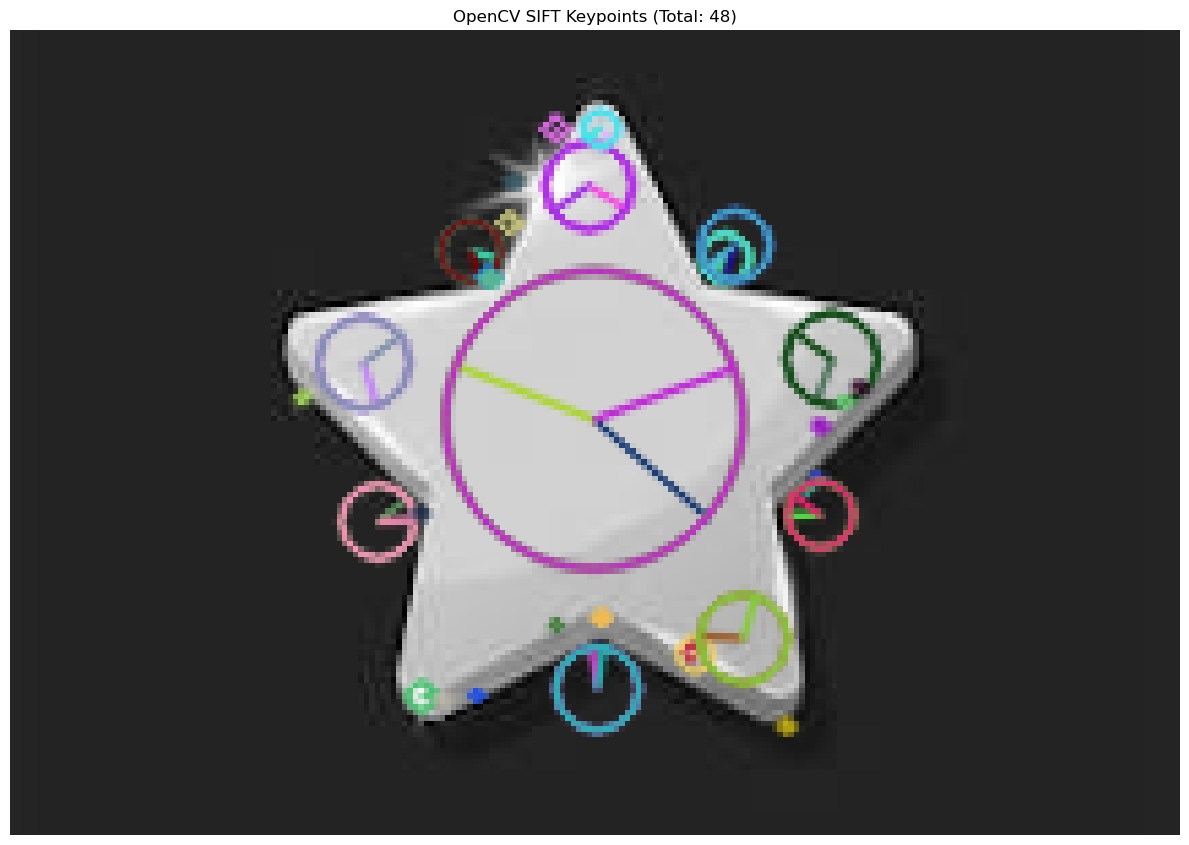


COMPARISON SUMMARY
Custom Implementation: 1040 keypoints, (1040, 128)
OpenCV Implementation: 48 keypoints, (48, 128)
Keypoint ratio: 21.67x

Descriptor Statistics:
  Mean: 0.0317
  Std:  0.0825
  Min:  0.0000
  Max:  0.7060


In [ ]:

def compute_gradient_magnitude_orientation(image):
   
    Gx = cv2.Sobel(image.astype(np.float64), cv2.CV_64F, 1, 0, ksize=3)
    Gy = cv2.Sobel(image.astype(np.float64), cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(Gx**2 + Gy**2)
    orientation = (np.degrees(np.arctan2(Gy, Gx)) + 360) % 360
    return magnitude, orientation



def assign_orientation_to_keypoints(octaves, dog_octaves, keypoints, num_bins=36):
    """Assign dominant orientations to keypoints for rotation invariance."""
    oriented_keypoints = []
    bin_width = 360 / num_bins

    for (x_real, y_real, sigma, octave_i, dog_i) in keypoints:
       
        scale_factor = 2 ** octave_i
        x = int(x_real / scale_factor)
        y = int(y_real / scale_factor)
        
        
        gaussian_image = octaves[octave_i]['gaussian_images'][dog_i + 1]
        magnitude, orientation = compute_gradient_magnitude_orientation(gaussian_image)

       
        dog_image = dog_octaves[octave_i]['dog_images'][dog_i]
        response = abs(dog_image[y, x])

        h, w = gaussian_image.shape
        radius = int(round(1.5 * sigma))

    
        if x < radius or y < radius or x >= (w - radius) or y >= (h - radius):
            continue

        
        patch_mag = magnitude[y - radius:y + radius + 1,
                              x - radius:x + radius + 1]
        patch_ori = orientation[y - radius:y + radius + 1,
                                x - radius:x + radius + 1]

     
        y_grid, x_grid = np.ogrid[-radius:radius+1, -radius:radius+1]
        gaussian_weight = np.exp(-(x_grid**2 + y_grid**2) / (2 * (1.5 * sigma)**2))

       
        hist = np.zeros(num_bins)
        for i in range(patch_ori.shape[0]):
            for j in range(patch_ori.shape[1]):
                angle = patch_ori[i, j]
                bin_idx = int(angle // bin_width) % num_bins
                hist[bin_idx] += patch_mag[i, j] * gaussian_weight[i, j]

        
        hist_padded = np.concatenate([hist[-3:], hist, hist[:3]])
        kernel = np.array([1, 4, 6, 4, 1]) / 16.0
        hist_smooth = np.convolve(hist_padded, kernel, mode='valid')

       
        max_val = np.max(hist_smooth)
        if max_val == 0:
            continue
            
     
        dominant_bins = np.where(hist_smooth >= 0.8 * max_val)[0]

        for b in dominant_bins:
           
            prev_val = hist_smooth[(b - 1) % num_bins]
            curr_val = hist_smooth[b]
            next_val = hist_smooth[(b + 1) % num_bins]
            
            interp_offset = 0.5 * (prev_val - next_val) / (prev_val - 2*curr_val + next_val + 1e-10)
            bin_refined = (b + interp_offset) % num_bins
            theta = bin_refined * bin_width
            
            oriented_keypoints.append((x_real, y_real, sigma, octave_i, dog_i, theta, response))

    return oriented_keypoints

def non_maximum_suppression(oriented_keypoints, radius=10):
    
    if len(oriented_keypoints) == 0:
        return []
 
    sorted_kps = sorted(oriented_keypoints, key=lambda x: x[6], reverse=True)
    
    filtered = []
    
    for kp in sorted_kps:
        x, y, sigma, octave, dog, theta, response = kp
        
        
        too_close = False
        for (x2, y2, sigma2, _, _, _, _) in filtered:
            dist = np.sqrt((x - x2)**2 + (y - y2)**2)
            
            min_sigma = min(sigma, sigma2)
            if dist < radius * min_sigma:
                too_close = True
                break
        
        if not too_close:
            filtered.append(kp)
    
    return filtered



def compute_sift_descriptors(octaves, oriented_keypoints):
    """Generate 128-dimensional SIFT descriptors."""
    descriptors = []
    valid_keypoints = []
    
    for (x_real, y_real, sigma, octave_i, dog_i, theta, response) in oriented_keypoints:
        
        scale_factor = 2 ** octave_i
        x = int(x_real / scale_factor)
        y = int(y_real / scale_factor)
        
        
        gaussian_image = octaves[octave_i]['gaussian_images'][dog_i + 1]
        magnitude, orientation = compute_gradient_magnitude_orientation(gaussian_image)

        h, w = gaussian_image.shape
        
       
        patch_radius = 8
        
        if x < patch_radius or y < patch_radius or x >= (w - patch_radius) or y >= (h - patch_radius):
            continue

        
        patch_mag = magnitude[y - patch_radius:y + patch_radius,
                              x - patch_radius:x + patch_radius]
        patch_ori = orientation[y - patch_radius:y + patch_radius,
                                x - patch_radius:x + patch_radius]

        if patch_mag.shape[0] != 16 or patch_mag.shape[1] != 16:
            continue

      
        rel_ori = (patch_ori - theta + 360) % 360

        
        y_grid, x_grid = np.ogrid[-patch_radius:patch_radius, -patch_radius:patch_radius]
        gaussian_weight = np.exp(-(x_grid**2 + y_grid**2) / (2 * (8)**2))
        weighted_mag = patch_mag * gaussian_weight

        descriptor = []

       
        for i in range(4):
            for j in range(4):
                y_start = i * 4
                y_end = y_start + 4
                x_start = j * 4
                x_end = x_start + 4

                sub_mag = weighted_mag[y_start:y_end, x_start:x_end]
                sub_ori = rel_ori[y_start:y_end, x_start:x_end]

               
                hist = np.zeros(8)
                bin_width = 360 / 8
                
                for di in range(4):
                    for dj in range(4):
                        mag_val = sub_mag[di, dj]
                        ori_val = sub_ori[di, dj]
                        
                        
                        bin_float = ori_val / bin_width
                        bin_low = int(np.floor(bin_float)) % 8
                        bin_high = (bin_low + 1) % 8
                        weight_high = bin_float - np.floor(bin_float)
                        weight_low = 1 - weight_high
                        
                        hist[bin_low] += mag_val * weight_low
                        hist[bin_high] += mag_val * weight_high
                
                descriptor.extend(hist)

     
        descriptor = np.array(descriptor, dtype=np.float32)
        
     
        norm = np.linalg.norm(descriptor)
        if norm > 0:
            descriptor /= norm
        
      
        descriptor = np.clip(descriptor, 0, 0.2)
        norm = np.linalg.norm(descriptor)
        if norm > 0:
            descriptor /= norm

        descriptors.append(descriptor)
        valid_keypoints.append((x_real, y_real, sigma, octave_i, dog_i, theta))

    return np.array(descriptors), valid_keypoints


def visualize_oriented_keypoints(image_path, oriented_keypoints, max_display=500):
   
    img_color = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 12))
    plt.imshow(img_rgb)
    plt.title(f"Keypoints with Orientation (showing {min(len(oriented_keypoints), max_display)} of {len(oriented_keypoints)})")
    plt.axis('off')

   
    display_kps = oriented_keypoints[:max_display]
    
    for kp in display_kps:
        x, y, sigma, octave, dog, theta = kp[:40]
        
        
        arrow_length = sigma * 4
        dx = arrow_length * np.cos(np.deg2rad(theta))
        dy = -arrow_length * np.sin(np.deg2rad(theta))
        
        
        circle = plt.Circle((x, y), sigma * 1.5, color='lime', fill=False, linewidth=2, alpha=0.6)
        plt.gca().add_patch(circle)
        
       
        plt.arrow(x, y, dx, dy, color='red', width=0.8, head_width=3, 
                 head_length=2, alpha=0.9, length_includes_head=True)
    
    plt.tight_layout()
    plt.show()



def compare_with_opencv(image_path):
    
    img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    sift = cv2.SIFT_create()
    kps, desc = sift.detectAndCompute(img_gray, None)

    print(f"\nOpenCV SIFT: {len(kps)} keypoints, Descriptor shape: {desc.shape}")
    
    img_sift = cv2.drawKeypoints(img_gray, kps, None,
                                 flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img_sift_rgb = cv2.cvtColor(img_sift, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 12))
    plt.imshow(img_sift_rgb)
    plt.title(f"OpenCV SIFT Keypoints (Total: {len(kps)})")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return kps, desc



print("Step 1: Assigning orientations to keypoints...")
oriented_keypoints = assign_orientation_to_keypoints(octaves, dog_octaves, keypoints)
print(f"Initial oriented keypoints: {len(oriented_keypoints)}")

print("\nStep 2: Applying non-maximum suppression...")
oriented_keypoints = non_maximum_suppression(oriented_keypoints, radius=2.0)
print(f"After NMS: {len(oriented_keypoints)}")

print("\nStep 3: Computing SIFT descriptors...")
descriptors, valid_keypoints = compute_sift_descriptors(octaves, oriented_keypoints)
print(f"Valid descriptors: {descriptors.shape}")
print(f"Each descriptor is {descriptors.shape[1] if len(descriptors) > 0 else 0}-dimensional")

print("\nStep 4: Visualizing keypoints with orientations...")
visualize_oriented_keypoints('star.jpeg', valid_keypoints)

print("\nStep 5: Comparing with OpenCV SIFT...")
opencv_kps, opencv_desc = compare_with_opencv('star.jpeg')

print("\n" + "="*70)
print("COMPARISON SUMMARY")
print("="*70)
print(f"Custom Implementation: {len(valid_keypoints)} keypoints, {descriptors.shape}")
print(f"OpenCV Implementation: {len(opencv_kps)} keypoints, {opencv_desc.shape}")
print(f"Keypoint ratio: {len(valid_keypoints) / len(opencv_kps):.2f}x")
print("="*70)


